In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm as progressbar
from transformers import AutoTokenizer, AutoModel
import pickle
import torch
import torch.nn.functional as F

### Loading preprocessed deduped data

In [2]:
df = pd.read_csv('../preprocessed/attribute.seqs.tsv', sep = '\t', names=['name', 'text']).dropna()

In [3]:
classes=df.groupby(by=["name"]).count().reset_index()
classes_sorted = classes.sort_values(by='text', ascending=True) #.name.values
classes_sorted.tail(5)

,name,text
22,isolate_run,4483
29,sample_comment_sam,5003
0,bio_material_sam,9295
24,misc_param_sam,10739
10,description_sam,17233


### Loading pretrained tokenizer and model

In [4]:
NAMESPACE='pubmedbert'

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuml/pubmedbert-base-embeddings')

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
%load_ext autoreload
%autoreload 2

from vocaverlap import VocabOverlap

In [7]:
%%time        
def if_oov(t):
    tt = tokenizer.tokenize(t)
    if tt is None or len(tt) == 0:
        return True
    if len(tt) == 1:
        return False
    if (len(tt) * 1.0)/len(t) >= 0.5:
        return True
    return False

vo = VocabOverlap(df[['name', 'text']].values).apply(if_oov)

with open(f'../preprocessed/attribute.token-freqs.{NAMESPACE}.info.pickle', 'wb') as f:
    pickle.dump(vo.info, f, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 4.33 s, sys: 20.1 ms, total: 4.35 s
Wall time: 4.32 s


In [32]:
def get_vocab_oov_dist(model_name):
    _j = pickle.load(open(f'../preprocessed/attribute.token-freqs.{model_name}.info.pickle', 'rb'))
    _dis = []
    
    for k, v in _j.items():
        _dis.append([k, 1-v['oov_tokens']/v['tokens'], 1-v['oov_uniq']/v['uniq']])

    _df = pd.DataFrame(sorted(_dis, key=lambda x :x[2], reverse=True), columns = ['name', 'r_tokens', 'r_uniq'])
    _df.name = _df.name.str.encode('utf-8')
    return _df

In [36]:
d1 = get_vocab_oov_dist('sbert')
d2 = get_vocab_oov_dist(NAMESPACE)

In [49]:
joined = pd.merge(d1.assign(name=d1.name.astype(str)), 
                  d2.assign(name=d2.name.astype(str)), how='inner', on='name')

In [50]:
joined.head()

,name,r_tokens_x,r_uniq_x,r_tokens_y,r_uniq_y
0,host_exp,1.000000,1.000000,1.000000,1.000000
1,single_cell_sam,1.000000,1.000000,1.000000,1.000000
2,extra_info_sam,0.927083,0.914286,0.958333,0.942857
3,isolation_site_sam,0.949654,0.902344,0.952616,0.906250
4,taxonomy_species_sam,0.870998,0.878241,0.869115,0.874859


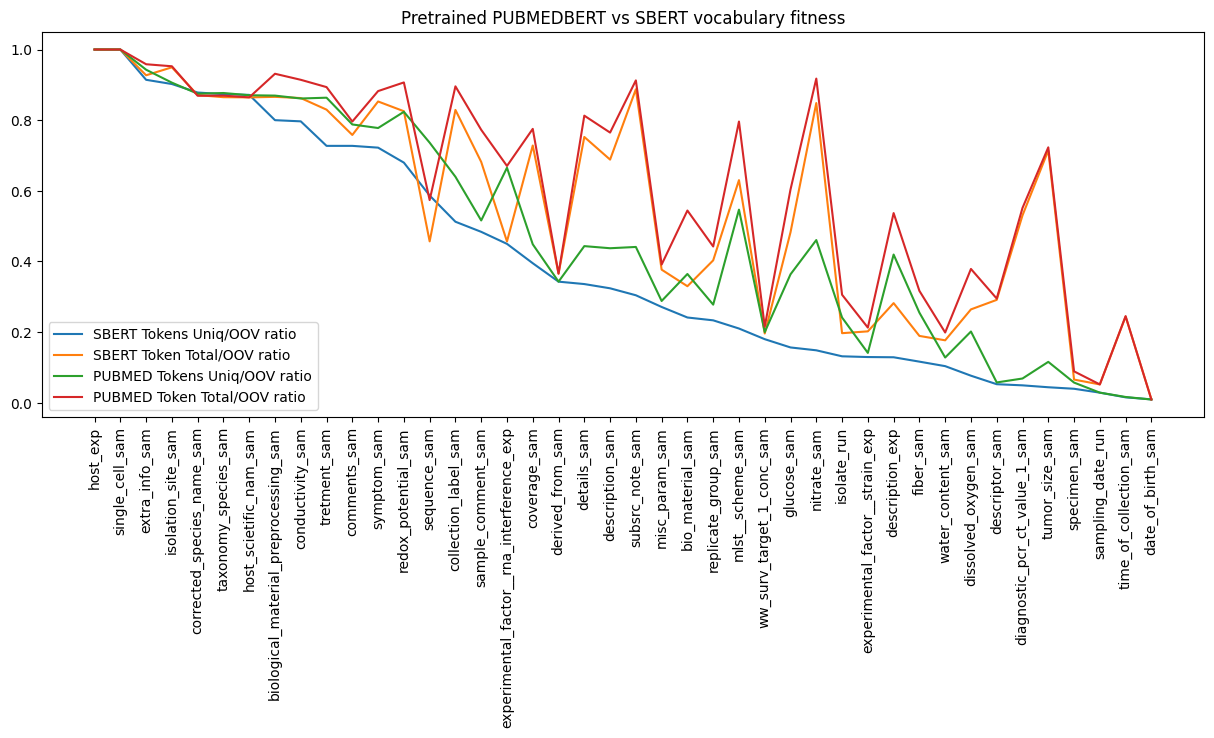

In [51]:
plt.figure(figsize=(15,5))
plt.plot(joined['r_uniq_x'])
plt.plot(joined['r_tokens_x'])
plt.plot(joined['r_uniq_y'])
plt.plot(joined['r_tokens_y'])
plt.title(f'Pretrained {NAMESPACE.upper()} vs SBERT vocabulary fitness')
plt.xticks(range(0, df_distribution.shape[0]), df_distribution['name'], rotation='vertical')
plt.legend(['SBERT Tokens Uniq/OOV ratio', 
            'SBERT Token Total/OOV ratio', 
            'PUBMED Tokens Uniq/OOV ratio', 
            'PUBMED Token Total/OOV ratio'], loc='lower left')
plt.show()